# AutoGen Assistant Agent

## Load Azure Configuration

In [1]:
from dotenv import load_dotenv
import os

azure_openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_openai_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_openai_deployment = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
azure_openai_api_version = os.getenv("AZURE_OPENAI_API_VERSION")

## Create Azure OpenAI Client
Using the model client class

In [2]:
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

# Create the token provider
#token_provider = get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default")

az_model_client = AzureOpenAIChatCompletionClient(
    azure_deployment=azure_openai_deployment,
    model=azure_openai_deployment,
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint,
    # azure_ad_token_provider=token_provider,  # Optional if you choose key-based authentication.
    api_key=azure_openai_key, # For key-based authentication.
)

## Defining an Agent
AssistantAgent is a built-in agent that uses a language model and has the ability to use tools.

In [3]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.ui import Console
from autogen_core import CancellationToken

# Define a tool
async def get_weather(city: str) -> str:
    return f"The weather in {city} is 73 degrees and Sunny."

# Define an agent
weather_agent = AssistantAgent(
    name="weather_agent",
    description="This agent provides weather information.",
    model_client=az_model_client,
    tools=[get_weather],
    system_message="""
    You are agent that assists with weather information.
    If you are given an image, you will identify the city in the image and provide the weather information. 
    If you are asked about other topics, tell the user you can only provide weather information.
    """,
)

## Text Message
Create a text message, which accepts a string content and a string source

In [4]:
from autogen_agentchat.messages import TextMessage

text_message = TextMessage(content="What's the weather in Chicago", source="User")

# Run the team and stream messages to the console.
stream = weather_agent.run_stream(task=text_message)
await Console(stream)

---------- User ----------
What's the weather in Chicago
---------- weather_agent ----------
[FunctionCall(id='call_1mRmi9aWsCwmz2HSPWDBvRX2', arguments='{"city":"Chicago"}', name='get_weather')]
---------- weather_agent ----------
[FunctionExecutionResult(content='The weather in Chicago is 73 degrees and Sunny.', call_id='call_1mRmi9aWsCwmz2HSPWDBvRX2')]
---------- weather_agent ----------
The weather in Chicago is 73 degrees and Sunny.


TaskResult(messages=[TextMessage(source='User', models_usage=None, content="What's the weather in Chicago", type='TextMessage'), ToolCallRequestEvent(source='weather_agent', models_usage=RequestUsage(prompt_tokens=104, completion_tokens=15), content=[FunctionCall(id='call_1mRmi9aWsCwmz2HSPWDBvRX2', arguments='{"city":"Chicago"}', name='get_weather')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(source='weather_agent', models_usage=None, content=[FunctionExecutionResult(content='The weather in Chicago is 73 degrees and Sunny.', call_id='call_1mRmi9aWsCwmz2HSPWDBvRX2')], type='ToolCallExecutionEvent'), ToolCallSummaryMessage(source='weather_agent', models_usage=None, content='The weather in Chicago is 73 degrees and Sunny.', type='ToolCallSummaryMessage')], stop_reason=None)

## MultiModal Message

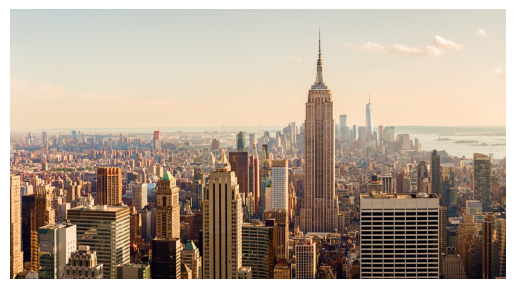

---------- User ----------
What's the weather in this image?
<image>
---------- weather_agent ----------
[FunctionCall(id='call_IuFFVFHu7DenBDsVc8WiVSSq', arguments='{"city":"New York"}', name='get_weather')]
---------- weather_agent ----------
[FunctionExecutionResult(content='The weather in New York is 73 degrees and Sunny.', call_id='call_IuFFVFHu7DenBDsVc8WiVSSq')]
---------- weather_agent ----------
The weather in New York is 73 degrees and Sunny.


TaskResult(messages=[MultiModalMessage(source='User', models_usage=None, content=["What's the weather in this image?", <autogen_core._image.Image object at 0x779a2054b410>], type='MultiModalMessage'), ToolCallRequestEvent(source='weather_agent', models_usage=RequestUsage(prompt_tokens=36988, completion_tokens=15), content=[FunctionCall(id='call_IuFFVFHu7DenBDsVc8WiVSSq', arguments='{"city":"New York"}', name='get_weather')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(source='weather_agent', models_usage=None, content=[FunctionExecutionResult(content='The weather in New York is 73 degrees and Sunny.', call_id='call_IuFFVFHu7DenBDsVc8WiVSSq')], type='ToolCallExecutionEvent'), ToolCallSummaryMessage(source='weather_agent', models_usage=None, content='The weather in New York is 73 degrees and Sunny.', type='ToolCallSummaryMessage')], stop_reason=None)

In [5]:
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import Image as AGImage
from PIL import Image
from matplotlib import pyplot as plt
import cv2

img_path = "../Data/images/AdobeStock_186373174.jpeg"

# Load the image using OpenCV.
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
# Convert the image from BGR to RGB for displaying with matplotlib, because OpenCV uses BGR by default and matplotlib expects RGB.
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image with matplotlib.
plt.imshow(img_rgb)
plt.axis("off")  # Turn off axis labels.
plt.show()

raw_image = Image.open(img_path)
# Create an AGImage object from the raw image.
img = AGImage(raw_image)
multi_modal_message = MultiModalMessage(content=["What's the weather in this image?", img], source="User")

# Run the team and stream messages to the console.
stream = weather_agent.run_stream(task=multi_modal_message)
await Console(stream)

## Agents have State

In [6]:
text_message = TextMessage(content="What were the cities again that I asked about the weather?", source="User")

# Run the team and stream messages to the console.
stream = weather_agent.run_stream(task=text_message)
await Console(stream)

---------- User ----------
What were the cities again that I asked about the weather?
---------- weather_agent ----------
You asked about the weather in Chicago and New York.


TaskResult(messages=[TextMessage(source='User', models_usage=None, content='What were the cities again that I asked about the weather?', type='TextMessage'), TextMessage(source='weather_agent', models_usage=RequestUsage(prompt_tokens=37044, completion_tokens=12), content='You asked about the weather in Chicago and New York.', type='TextMessage')], stop_reason=None)

## Getting Responses

1. on_messages() method returns a Response that contains the following attributes:
- chat_message: contains agent’s final response 
- inner_messages: stores the agent’s “thought process” that led to the final response.
2. on_messages() will update the internal state of the agent – it will add the messages to the agent’s history. 
- You should call this method with new messages.
- You should NOT repeatedly call this method with the same messages or the complete history.

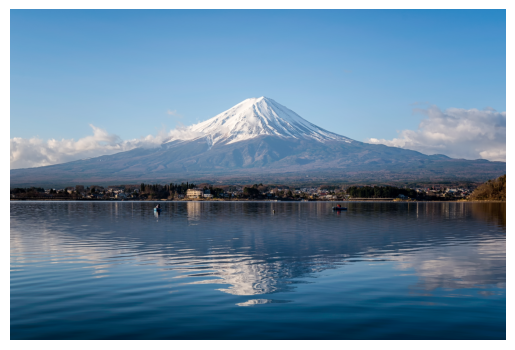

Thought process: 
[]


Final Response: 
source='weather_agent' models_usage=RequestUsage(prompt_tokens=73917, completion_tokens=28) content="I'm only able to provide weather information. If you can provide me with the city name, I can assist you with the weather there." type='TextMessage'


Final Response Content: 
I'm only able to provide weather information. If you can provide me with the city name, I can assist you with the weather there.


In [7]:
img_path = "../Data/images/AdobeStock_192483501.jpeg"

img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
# Convert the image from BGR to RGB for displaying with matplotlib, because OpenCV uses BGR by default and matplotlib expects RGB.
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image with matplotlib.
plt.imshow(img_rgb)
plt.axis("off")  # Turn off axis labels.
plt.show()

raw_image = Image.open(img_path )
# Create an AGImage object from the raw image.
img = AGImage(raw_image)
multi_modal_message = MultiModalMessage(content=["What's the city where this image is located? Provide the weather there.", img], source="User")

cancellation_token=CancellationToken()
response = await weather_agent.on_messages(
    [multi_modal_message],
    cancellation_token=cancellation_token,
)
# contains the agent's "thought process"
print("Thought process: ")
print(response.inner_messages)
print("\n")
# contains the agent's final response
print("Final Response: ")
print(response.chat_message)
print("\n")
print("Final Response Content: ")
print(response.chat_message.content)

## Streaming Messages
We can also stream each message as it is generated by the agent by using the on_messages_stream() method, and use Console to print the messages as they appear to the console.

In [8]:
text_message = TextMessage(content="What were the cities again that I asked about the weather?", source="User")

from IPython.display import display

cancellation_token=CancellationToken()
await Console(weather_agent.on_messages_stream(
        [text_message],
        cancellation_token=cancellation_token,)
    )

---------- weather_agent ----------
You asked about the weather in Chicago and New York.


Response(chat_message=TextMessage(source='weather_agent', models_usage=RequestUsage(prompt_tokens=73969, completion_tokens=12), content='You asked about the weather in Chicago and New York.', type='TextMessage'), inner_messages=[])

## Reset Agent to Initial State

In [9]:
cancellation_token=CancellationToken()
# Reset the agent
await weather_agent.on_reset(cancellation_token=cancellation_token)

text_message = TextMessage(content="What were the cities again that I asked about the weather?", source="User")
response = await weather_agent.on_messages(
        [text_message],
        cancellation_token=cancellation_token,
    )
print(response.chat_message.content)

# Reset the agent again
await weather_agent.on_reset(cancellation_token=cancellation_token)



I can only provide weather information. Please let me know which city you would like to inquire about.


## Using Model Context
AssistantAgent has a model_context parameter that can be used to pass in a ChatCompletionContext object. This allows the agent to use different model contexts, such as BufferedChatCompletionContext to limit the context sent to the model.

By default, AssistantAgent uses the UnboundedChatCompletionContext which sends the full conversation history to the model. To limit the context to the last n messages, you can use the BufferedChatCompletionContext.

In [10]:
from autogen_core.model_context import BufferedChatCompletionContext
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.ui import Console
from autogen_core import CancellationToken
from autogen_agentchat.messages import TextMessage

# Define a tool
async def get_weather(city: str) -> str:
    return f"The weather in {city} is 73 degrees and Sunny."

# Define an agent
weather_agent = AssistantAgent(
    name="weather_agent",
    description="This agent provides weather information.",
    model_client=az_model_client,
    tools=[get_weather],
    system_message="""
    You are agent that assists with weather information.
    """,
    model_context=BufferedChatCompletionContext(buffer_size=8),  
)

In [11]:
text_message = TextMessage(content="What is the weather in Chicago?", source="User")
stream = weather_agent.run_stream(task=text_message)
await Console(stream)
print("\n")

text_message = TextMessage(content="How about in New York?", source="User")
stream = weather_agent.run_stream(task=text_message)
await Console(stream)
print("\n")

text_message = TextMessage(content="What's it like in Tokyo?", source="User")
stream = weather_agent.run_stream(task=text_message)
await Console(stream)
print("\n")

---------- User ----------
What is the weather in Chicago?
---------- weather_agent ----------
[FunctionCall(id='call_WBkjkx24J3BcUyCm24UJ9RG4', arguments='{"city":"Chicago"}', name='get_weather')]
---------- weather_agent ----------
[FunctionExecutionResult(content='The weather in Chicago is 73 degrees and Sunny.', call_id='call_WBkjkx24J3BcUyCm24UJ9RG4')]
---------- weather_agent ----------
The weather in Chicago is 73 degrees and Sunny.


---------- User ----------
How about in New York?
---------- weather_agent ----------
[FunctionCall(id='call_qcdyHpXIYcXyqtjzHStul32z', arguments='{"city":"New York"}', name='get_weather')]
---------- weather_agent ----------
[FunctionExecutionResult(content='The weather in New York is 73 degrees and Sunny.', call_id='call_qcdyHpXIYcXyqtjzHStul32z')]
---------- weather_agent ----------
The weather in New York is 73 degrees and Sunny.


---------- User ----------
What's it like in Tokyo?
---------- weather_agent ----------
[FunctionCall(id='call_D7w

In [12]:
text_message = TextMessage(content="What was the weather in the first city again?", source="User")
stream = weather_agent.run_stream(task=text_message)
await Console(stream)
print("\n")

## New York is the first city in the context given that each interaction was 4 messages.

---------- User ----------
What was the weather in the first city again?
---------- weather_agent ----------
The weather in New York is 73 degrees and Sunny.




# Save and Load Agent State

In [13]:
import json

state = await weather_agent.save_state()

# (Optional) Write state to disk.
with open("assistant_state.json", "w") as f:
    json.dump(state, f)

# (Optional) Load it back from disk.
with open("assistant_state.json", "r") as f:
    state = json.load(f)
    print(state) # Inspect the state, which contains the chat history.

# Carry on the chat.
response = await weather_agent.on_messages([TextMessage(content="What is the weather in Rome?", source="user")], cancellation_token=CancellationToken())
print(response.chat_message.content)


{'type': 'AssistantAgentState', 'version': '1.0.0', 'llm_context': {'messages': [{'content': 'What is the weather in Chicago?', 'source': 'User', 'type': 'UserMessage'}, {'content': [{'id': 'call_WBkjkx24J3BcUyCm24UJ9RG4', 'arguments': '{"city":"Chicago"}', 'name': 'get_weather'}], 'source': 'weather_agent', 'type': 'AssistantMessage'}, {'content': [{'content': 'The weather in Chicago is 73 degrees and Sunny.', 'call_id': 'call_WBkjkx24J3BcUyCm24UJ9RG4'}], 'type': 'FunctionExecutionResultMessage'}, {'content': 'How about in New York?', 'source': 'User', 'type': 'UserMessage'}, {'content': [{'id': 'call_qcdyHpXIYcXyqtjzHStul32z', 'arguments': '{"city":"New York"}', 'name': 'get_weather'}], 'source': 'weather_agent', 'type': 'AssistantMessage'}, {'content': [{'content': 'The weather in New York is 73 degrees and Sunny.', 'call_id': 'call_qcdyHpXIYcXyqtjzHStul32z'}], 'type': 'FunctionExecutionResultMessage'}, {'content': "What's it like in Tokyo?", 'source': 'User', 'type': 'UserMessage'}

In [14]:
# Carry on the same chat again.
response = await weather_agent.on_messages([TextMessage(content="What was the weather in the first city again?", source="user")], cancellation_token=CancellationToken())
print(response.chat_message.content)

The weather in Tokyo is 73 degrees and Sunny.


In [15]:

# Load the state, resulting the agent to revert to the previous state before the last message.
await weather_agent.load_state(state)

# Carry on the same chat again.
response = await weather_agent.on_messages([TextMessage(content="What was the weather in the first city again?", source="user")], cancellation_token=CancellationToken())
print(response.chat_message.content)

The weather in New York is 73 degrees and Sunny.
